In [1]:
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import pandas as pd
from collections import defaultdict
from IPython.display import clear_output

import sys
sys.path.append("ComputeCanada/frequency_tagging")
sys.path.append("/opt/supervenn")
from supervenn import supervenn
from utils import (
    get_roi_colour_codes,
    change_font,
    HCP_ATLAS as hcp_label,
    im_generate_single_subject_maps,
    NORMAL_3T_SUB_IDS,
    NORMAL_7T_SUB_IDS,
    VARY_SUB_IDS,
    VARY_020_ENTRAIN_CONDITIONS,
    VARY_021_ENTRAIN_CONDITIONS,
    PICKLE_DIR,
    get_frequency_text_codes,
    MAIN,
)
change_font()

tmpdir = Path("/tmp")

ROI_FO = .8
corr_type = "uncp"
FORCE_RUN = False


im_map_pkl = PICKLE_DIR / f"im_map_fo-{ROI_FO}_corr-{corr_type}.pkl" # Generated from `5_0_im_generate_maps.ipynb`
assert im_map_pkl.exists()

df = pd.read_pickle(im_map_pkl)
df.head(2)

,roi_task_id,roi_fo,experiment_id,sub_id,quadrant_id,hcp_roi,im_code,frequency_of_roi,frequency_coordinates,slab_coordinates,train_f_im_activation,train_f_im_phase_delay,test_f_im_BOLD_power,test_f_im_BOLD_psnr,test_f_im_phase_delay,tasklock
0,control,0.8,3TNormal,000,Q1,IPSI_V1,f1,0.125,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[0.0325, 0.0025, 0.01, 0.08, 0.47, 0.3525, 0.0...","[6.226649576650377, 5.417347389581846, 2.77230...","[2.7014301449810317e-05, 1.6126611955549207e-0...","[1.3732902201917023, 0.6774311885633506, 0.768...","[6.409281766453496, 5.861956327972003, 3.33177...","[-0.007829265716663156, 0.01971885710249069, 0..."
1,control,0.8,3TNormal,000,Q1,IPSI_MST,f1,0.125,"[False, False, False, False, False, False, Fal...","[False, False, False, False, False, False, Fal...","[0.0025, 0.01, 0.0575, 0.03, 0.0025, 0.09, 0.0...","[3.1071296199440805, 2.499630889017135, 2.3472...","[7.78974422742995e-06, 1.032021949438966e-05, ...","[0.7055335439840928, 1.272617283470172, 0.9067...","[2.8780188870476557, 2.428085706871934, 2.3632...","[0.06739370951749944, 0.05489127100062905, 0.0..."


In [2]:
"""Get HCP labels
"""
_HCP_INFO = !wb_command -file-information {hcp_label}
HCP_LABELS = []
HCP_COUNTER = 0
for i in _HCP_INFO:
    if len(i) == 60 and any(["L_" in i, "R_" in i]):
        hcp_colors = tuple([float(f"0.{k}") for k in [j.split(' ') [0] for j in i.split('0.')][-3:]] + [1])
        if ' R_' in i:
            roi = i.split("_ROI")[0].split(' R_')[1]
            HCP_LABELS.append(f"R_{roi}_ROI")
        if ' L_' in i:
            roi = i.split("_ROI")[0].split(' L_')[1]
            HCP_LABELS.append(f"L_{roi}_ROI")
        HCP_COUNTER += 1

"""Get HCP label coordinates
"""
hcp_mapping = {}
for roi_label in HCP_LABELS:
    out_dscalar = tmpdir / f"{roi_label}.dscalar.nii"
    if out_dscalar.exists():
        hcp_mapping[roi_label] = out_dscalar
        continue
    !wb_command -cifti-label-to-roi {hcp_label} {out_dscalar} -name {roi_label}
    assert out_dscalar.exists(), f"{out_dscalar.stem} does not exist."
    hcp_mapping[roi_label] = out_dscalar
hcp_rois = list(set([k.split('_')[1] for k in hcp_mapping.keys()]))

In [3]:
dscalar_dir = Path("/opt/app/notebooks/data/dscalars")
surface_dir = Path("/opt/app/notebooks/data/surfaces")
tmpdir = Path("/tmp")
L_mid = surface_dir / "S1200.L.midthickness_MSMAll.32k_fs_LR.surf.gii"
R_mid = surface_dir / "S1200.R.midthickness_MSMAll.32k_fs_LR.surf.gii"
L_geo = tmpdir / "L.dconn.nii"
R_geo = tmpdir / "R.dconn.nii"
!wb_command -surface-geodesic-distance-all-to-all {L_mid} {L_geo}
!wb_command -surface-geodesic-distance-all-to-all {R_mid} {R_geo}

template_dscalar = dscalar_dir / "S1200.MyelinMap_BC_MSMAll.32k_fs_LR.dscalar.nii"
L_V1_ROI = tmpdir / "L_V1_ROI.dscalar.nii"
R_V1_ROI = tmpdir / "R_V1_ROI.dscalar.nii"
L_V1_GD = tmpdir / "L_V1_ROI.gd.dscalar.nii"
R_V1_GD = tmpdir / "R_V1_ROI.gd.dscalar.nii"
    
!wb_command -cifti-create-dense-from-template {template_dscalar} {L_V1_GD} -cifti {L_V1_ROI}
!wb_command -cifti-create-dense-from-template {template_dscalar} {R_V1_GD} -cifti {R_V1_ROI}

L_V1_coords = nib.load(L_V1_GD).get_fdata()[0,:32492]==1
_L_geo = nib.load(L_geo).get_fdata()
L_geo_arr = _L_geo[L_V1_coords,:].mean(0)
del _L_geo
R_V1_coords = nib.load(R_V1_GD).get_fdata()[0,32492:]==1
_R_geo = nib.load(R_geo).get_fdata()
R_geo_arr = _R_geo[R_V1_coords,:].mean(0)
del _R_geo

geo_arr = np.concatenate((L_geo_arr, R_geo_arr))

geodesic_dscalar = tmpdir / "geodesic_V1.dscalar.nii"
img = nib.load(L_V1_GD)
data = np.zeros(img.shape)
data[0,:] = geo_arr
geo_img = nib.Cifti2Image(data, header=img.header)
nib.save(geo_img, geodesic_dscalar)
!wb_command -cifti-create-dense-from-template {L_V1_ROI} {geodesic_dscalar} -cifti {geodesic_dscalar}

In [4]:
task_ids = []
experiment_ids = []
sub_ids = []
quadrant_ids = []
hcp_rois = []
im_codes = []
im_fs = []
fos = []
vertex_coordinates = []
vertex_powers = []

for row_ix, row in df.iterrows():
    vertex_coords = np.where(row.slab_coordinates)[0]
    assert vertex_coords.shape==row.train_f_im_activation.shape==row.test_f_im_BOLD_power.shape
    for _vertex, _fo, _power in zip(vertex_coords,row.train_f_im_activation,row.test_f_im_BOLD_power):
        if row.im_code not in ["f1","f2","f2-f1","2f1"]:
            continue
        task_ids.append(row.roi_task_id)
        experiment_ids.append(row.experiment_id)
        sub_ids.append(row.sub_id)
        quadrant_ids.append(row.quadrant_id)
        hcp_rois.append(row.hcp_roi)
        im_codes.append(row.im_code)
        im_fs.append(row.frequency_of_roi)
        fos.append(_fo)
        vertex_coordinates.append(_vertex)
        vertex_powers.append(_power)


expanded_df = pd.DataFrame(
    {
        "fo": fos,
        "task_id": task_ids,
        "experiment_id": experiment_ids,
        "sub_id": sub_ids,
        "quadrant_id": quadrant_ids,
        "hcp_roi": hcp_rois,
        "im_code": im_codes,
        "im_f": im_fs,
        "power": vertex_powers,
        "vertex_id": vertex_coordinates
    }
)
# Add hemi column
expanded_df["hemi"] = np.where(expanded_df.hcp_roi.str.startswith("CONTRA"), 1,0)
# Add geodesic distance column
from functools import lru_cache
@lru_cache(maxsize=180)
def _get_geodesic_distance(hcp_label):
    l_hcp_path = f"/tmp/L_{hcp_label}_ROI.dscalar.nii"
    r_hcp_path = f"/tmp/R_{hcp_label}_ROI.dscalar.nii"
    geo_l_data = geodesic_arr[nib.load(l_hcp_path).get_fdata()==1].mean()
    geo_r_data = geodesic_arr[nib.load(r_hcp_path).get_fdata()==1].mean()

    return np.mean([geo_l_data, geo_r_data])

def get_geodesic_distance(row):
    return _get_geodesic_distance(row.hcp_roi.split("_")[-1])

"""
def get_geodesic_distance(row):
    return geodesic_arr[0,row.vertex_id]
"""

geodesic_arr = np.array(nib.load(geodesic_dscalar).get_fdata())
expanded_df["geodesic_distance"] = expanded_df.apply(get_geodesic_distance, axis=1,)
expanded_df["experiment_sub_id"] = expanded_df.experiment_id + "_" + expanded_df.sub_id + "_" + expanded_df.task_id
# Add im_exists column
expanded_df["im_exists"] = (expanded_df.fo > .8).astype(int)


expanded_df

,fo,task_id,experiment_id,sub_id,quadrant_id,hcp_roi,im_code,im_f,power,vertex_id,hemi,geodesic_distance,experiment_sub_id,im_exists
0,0.0325,control,3TNormal,000,Q1,IPSI_V1,f1,0.125,0.000027,29749,0,25.210299,3TNormal_000_control,0
1,0.0025,control,3TNormal,000,Q1,IPSI_V1,f1,0.125,0.000016,29750,0,25.210299,3TNormal_000_control,0
2,0.0100,control,3TNormal,000,Q1,IPSI_V1,f1,0.125,0.000021,29751,0,25.210299,3TNormal_000_control,0
3,0.0800,control,3TNormal,000,Q1,IPSI_V1,f1,0.125,0.000026,29752,0,25.210299,3TNormal_000_control,0
4,0.4700,control,3TNormal,000,Q1,IPSI_V1,f1,0.125,0.000054,29753,0,25.210299,3TNormal_000_control,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3993282,0.0000,entrainF,7TVary,021,Q1,CONTRA_A4,2f1,0.350,0.000128,7960,1,120.562120,7TVary_021_entrainF,0
3993283,0.0000,entrainF,7TVary,021,Q1,CONTRA_A4,2f1,0.350,0.004510,7961,1,120.562120,7TVary_021_entrainF,0
3993284,0.0225,entrainF,7TVary,021,Q1,CONTRA_A4,2f1,0.350,0.000015,7986,1,120.562120,7TVary_021_entrainF,0
3993285,0.0000,entrainF,7TVary,021,Q1,CONTRA_A4,2f1,0.350,0.001208,7987,1,120.562120,7TVary_021_entrainF,0


In [5]:
from scipy import stats
import statsmodels.api as sm
import matplotlib.colors as mcolors

def generate_stats_dict_arr(power_to_models, n_experiments, n_params):
    stats_fill = dict()
    for k in power_to_models:
        stats_fill[k] = np.zeros((n_experiments,n_params))

    return stats_fill

def model_individual_powers(stats_fill,fill_row_id,expanded_df,independent_vars,power_to_models,experiment_id, sub_id, task_id, setting=1):

    sub_expanded_df = expanded_df[(expanded_df.sub_id==sub_id) & (expanded_df.experiment_id==experiment_id) & (expanded_df.task_id==task_id)]
    data_dict = defaultdict(list)
    for vertex_id in sub_expanded_df.vertex_id.unique():
        _df = sub_expanded_df[sub_expanded_df.vertex_id==vertex_id]
        nrows = _df.shape[0]
        if nrows!=4:
            print(f"Skipping: [{_df.hcp_roi.unique()}] {vertex_id} has {nrows} rows")
            continue
        for _, row in _df.iterrows():
            if row.im_code == "f1":
                binary_f1 = row.im_exists
                bold_power_f1 = row.power
            elif row.im_code == "f2":
                binary_f2 = row.im_exists
                bold_power_f2 = row.power
            elif row.im_code == "f2-f1":
                binary_f2_sub_f1 = row.im_exists
                bold_power_f2_sub_f1 = row.power
            elif row.im_code == "2f1":
                binary_2f1 = row.im_exists
                bold_power_2f1 = row.power
            else:
                raise ValueError(f"{row.im_code} not in {['f1','f2','f2-f1','2f1']}")
        data_dict["bold_power_f1"].append(bold_power_f1)
        data_dict["bold_power_f2"].append(bold_power_f2)
        data_dict["bold_power_f2_sub_f1"].append(bold_power_f2_sub_f1)
        data_dict["bold_power_2f1"].append(bold_power_2f1)
        data_dict["binary_f1"].append(binary_f1)
        data_dict["binary_f2"].append(binary_f2)
        data_dict["binary_f2_sub_f1"].append(binary_f2_sub_f1)
        data_dict["binary_2f1"].append(binary_2f1)
        data_dict["vertex_id"].append(vertex_id)
        data_dict["sub_id"].append(sub_id)
        data_dict["hcp_label"].append(row.hcp_roi)
        data_dict["hemi"].append(row.hemi)
        data_dict["geodesic_distance"].append(row.geodesic_distance)
        data_dict["experiment_sub_id"].append(row.experiment_sub_id)
    _df = pd.DataFrame(data_dict)
    _df = _df[~(pd.isna(_df.bold_power_f1))] 

    assert pd.isna(_df).sum().sum() == 0

    plot_df = _df.drop(columns=["sub_id","hcp_label","experiment_sub_id","vertex_id","geodesic_distance"])
    plot_df = (plot_df - plot_df.mean()) / plot_df.std()

    #fig, ax = plt.subplots(figsize=(2,1),dpi=300)
    #ax.imshow(plot_df, aspect="auto",vmax=1,vmin=-1)
    #ax.set_xticks([i for i in range(len(plot_df.columns))])
    #ax.set_xticklabels([i for i in plot_df.columns], fontsize=6,rotation=90)
    #ax.set_title(f"{experiment_id} {sub_id} {task_id}", fontsize= 4)

    # Filter power measures that have a Z-score threshold > 3[`threshold`] in the power measure columns
    threshold = 3
    filtered_df = _df[[i for i in _df.columns if i.startswith("bold_power")]]
    zscores = np.abs(stats.zscore(filtered_df))
    plot_df = plot_df[(zscores < threshold).all(axis=1)]
    _df = _df[(zscores<threshold).all(axis=1)]

    #fig, ax = plt.subplots(figsize=(2,1),dpi=300)
    #ax.imshow(plot_df, aspect="auto",vmax=1,vmin=-1)
    #ax.set_xticks([i for i in range(len(plot_df.columns))])
    #ax.set_xticklabels([i for i in plot_df.columns], fontsize=6,rotation=90)
    #ax.set_title(f"{experiment_id} {sub_id} {task_id}", fontsize= 4)

    X_dict, y_dict = {}, {}
    for power_to_model in power_to_models:
        y = _df[f"bold_power_{power_to_model}"]
        X = _df[independent_vars]
        
        """No filtering"""
        col_constant = []
        # Remove column if it is all constant   
        for col in X.columns:
            if len(X[col].unique()) == 1:
                X = X.drop(columns=col)
                col_constant.append(col)
                
        X = sm.add_constant(X)

        updated_independent_vars = independent_vars.copy()
        if setting == 1:
            if "binary_f1" not in col_constant and "binary_f2" not in col_constant:
                X["binary_f1*f2"] = X.binary_f1 * X.binary_f2 # Add f1 & f2 intersection
                updated_independent_vars.append("binary_f1*f2")

        if setting == 2:
            if "binary_f1" not in col_constant and "binary_f2" not in col_constant:
                X["binary_f1*f2"] = X.binary_f1 * X.binary_f2 # Add f1 & f2 intersection
                updated_independent_vars.append("binary_f1*f2")
            if "binary_f1" not in col_constant and "binary_f2" not in col_constant and "binary_f2_sub_f1" not in col_constant:
                X["binary_f1*f2*f2_sub_f1"] = X.binary_f1 * X.binary_f2 * X.binary_f2_sub_f1 # Add f1 & f2 intersection
                updated_independent_vars.append("binary_f1*f2*f2_sub_f1")
                X["binary_f1*f2_sub_f1"] = X.binary_f1 * X.binary_f2_sub_f1 # Add f1 & f2 intersection
                updated_independent_vars.append("binary_f1*f2_sub_f1")
                X["binary_f2*f2_sub_f1"] = X.binary_f2 * X.binary_f2_sub_f1 # Add f1 & f2 intersection
                updated_independent_vars.append("binary_f2*f2_sub_f1")
        
        model = sm.OLS(y,X).fit()
        for var_ix, v in enumerate(updated_independent_vars):
            stats_fill[power_to_model][fill_row_id,var_ix] = np.nan
            if v in col_constant:
                continue
            b = model.params[v]
            p = model.pvalues[v]
            if p<.05:
                stats_fill[power_to_model][fill_row_id,var_ix] = b
        
        X_dict[power_to_model] = X
        y_dict[power_to_model] = y

    return stats_fill, updated_independent_vars, X_dict, y_dict

def filter_experiments_with_frequency_encodings(df, hcp_roi, im_codes_to_include):
    """return list of experiment_sub_ids
    """
    df = df[(df.hcp_roi==hcp_roi)]
    experiment_sub_ids = []
    for experiment_sub_id in df.experiment_sub_id.unique():
        e_s_df = df[(df.experiment_sub_id==experiment_sub_id)]
        counter = 0
        for im_code in im_codes_to_include:
            im_exists_unique = e_s_df[(e_s_df.im_code==im_code)].im_exists.unique()
            if 1 in im_exists_unique:
                counter += 1
        if counter == len(im_codes_to_include):
            experiment_sub_ids.append(experiment_sub_id)

    return experiment_sub_ids

Setting 1
- model power f1 and f2
- use binarized f1, f2 and multiplex encoding 
- repeat across different HCP labels

0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
Skipping: [['CONTRA_V3']] 51159 has 1 rows
Skipping: [['CONTRA_V3']] 51370 has 1 rows
Skipping: [['CONTRA_V3']] 51371 has 1 rows
Skipping: [['CONTRA_V4']] 43005 has 1 rows
Skipping: [['CONTRA_V4']] 43115 has 1 rows
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
8.427080880291145e-05 0.0004596274565690751


posx and posy should be finite values
posx and posy should be finite values


0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
Skipping: [['CONTRA_V3']] 51159 has 1 rows
Skipping: [['CONTRA_V3']] 51370 has 1 rows
Skipping: [['CONTRA_V3']] 51371 has 1 rows
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
Skipping: [['CONTRA_V4']] 43005 has 1 rows
Skipping: [['CONTRA_V4']] 43115 has 1 rows
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain


posx and posy should be finite values


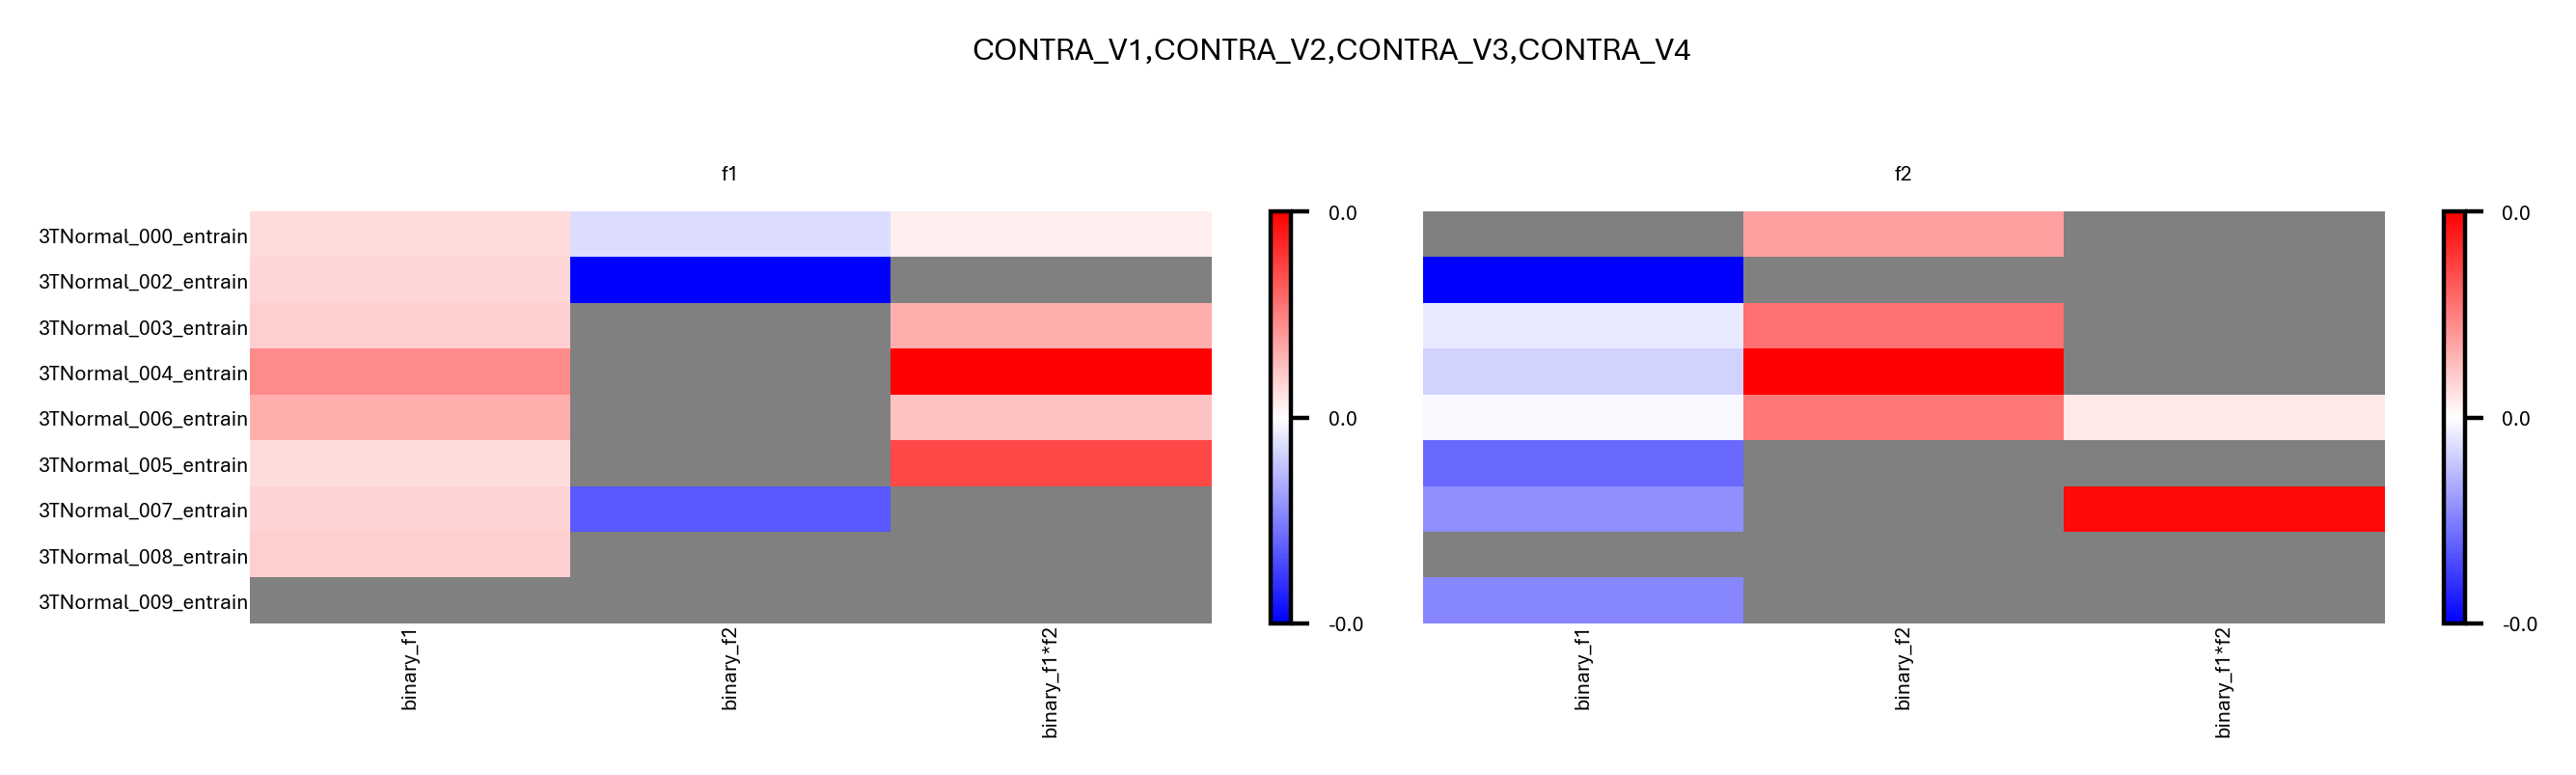

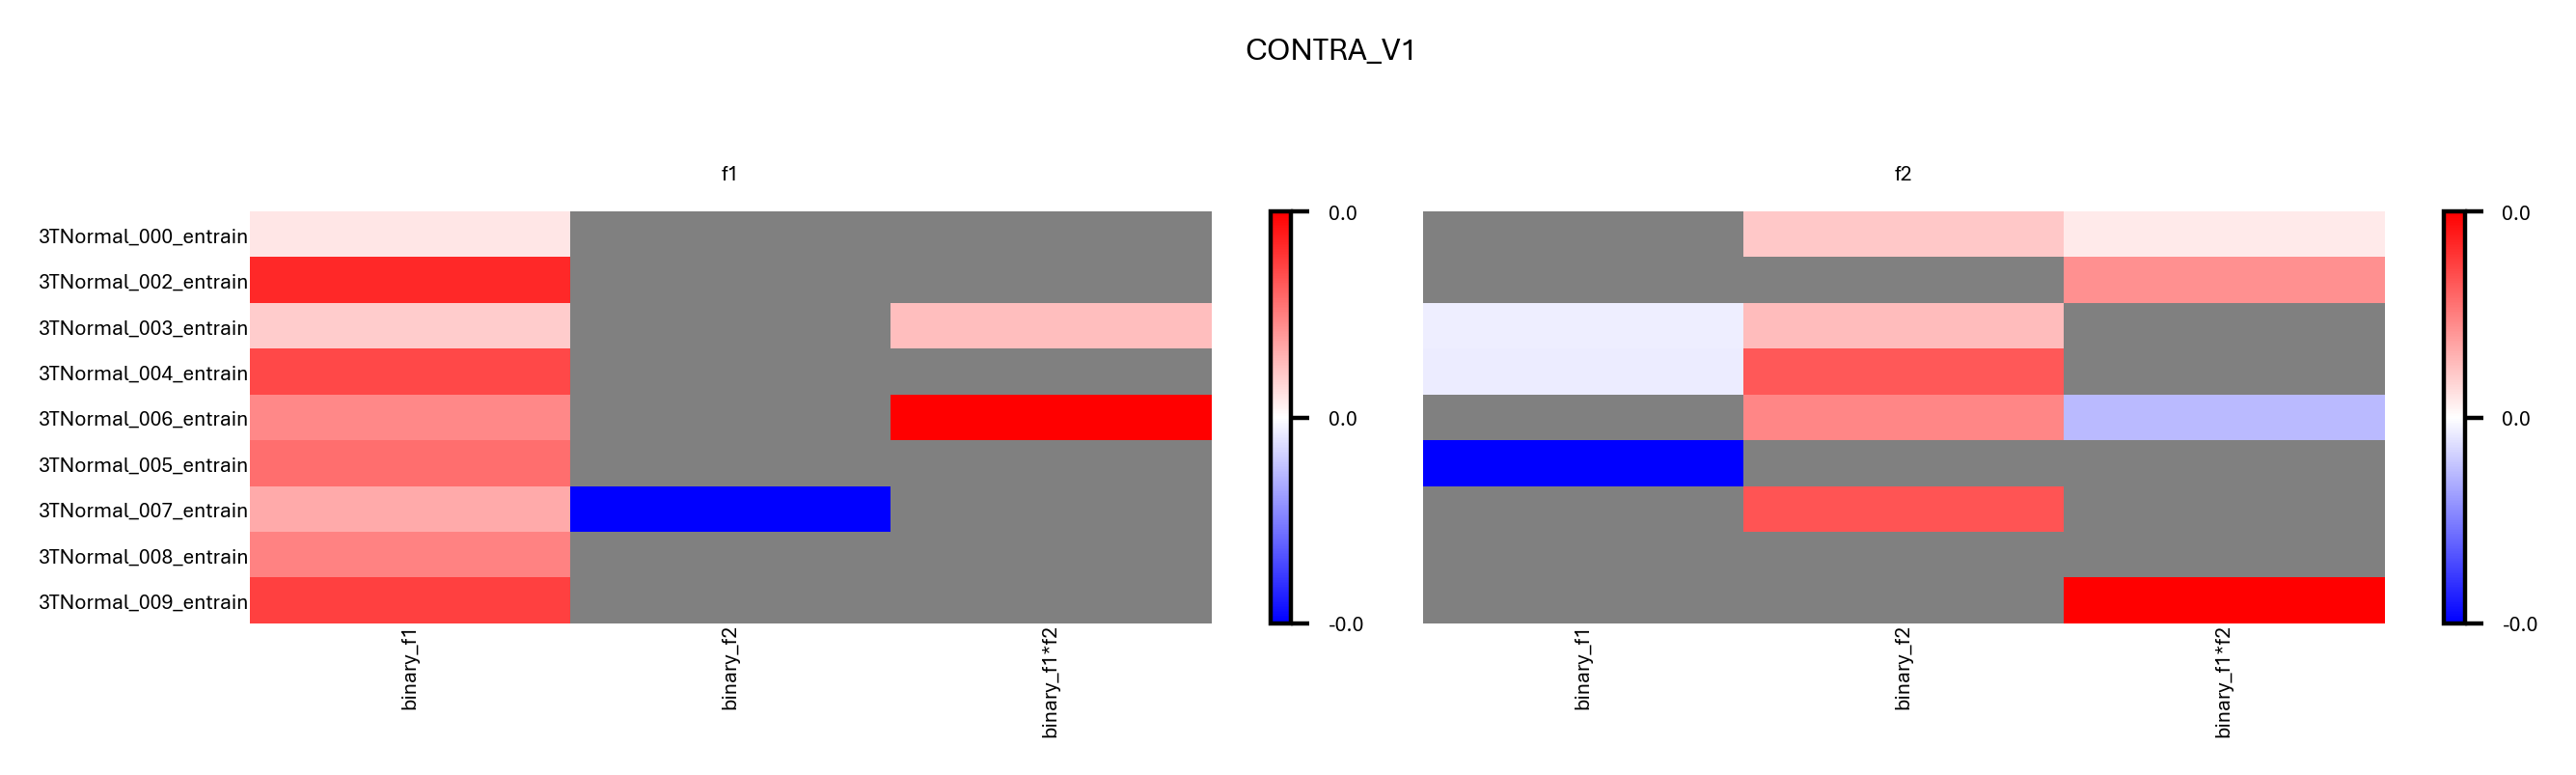

posx and posy should be finite values
posx and posy should be finite values


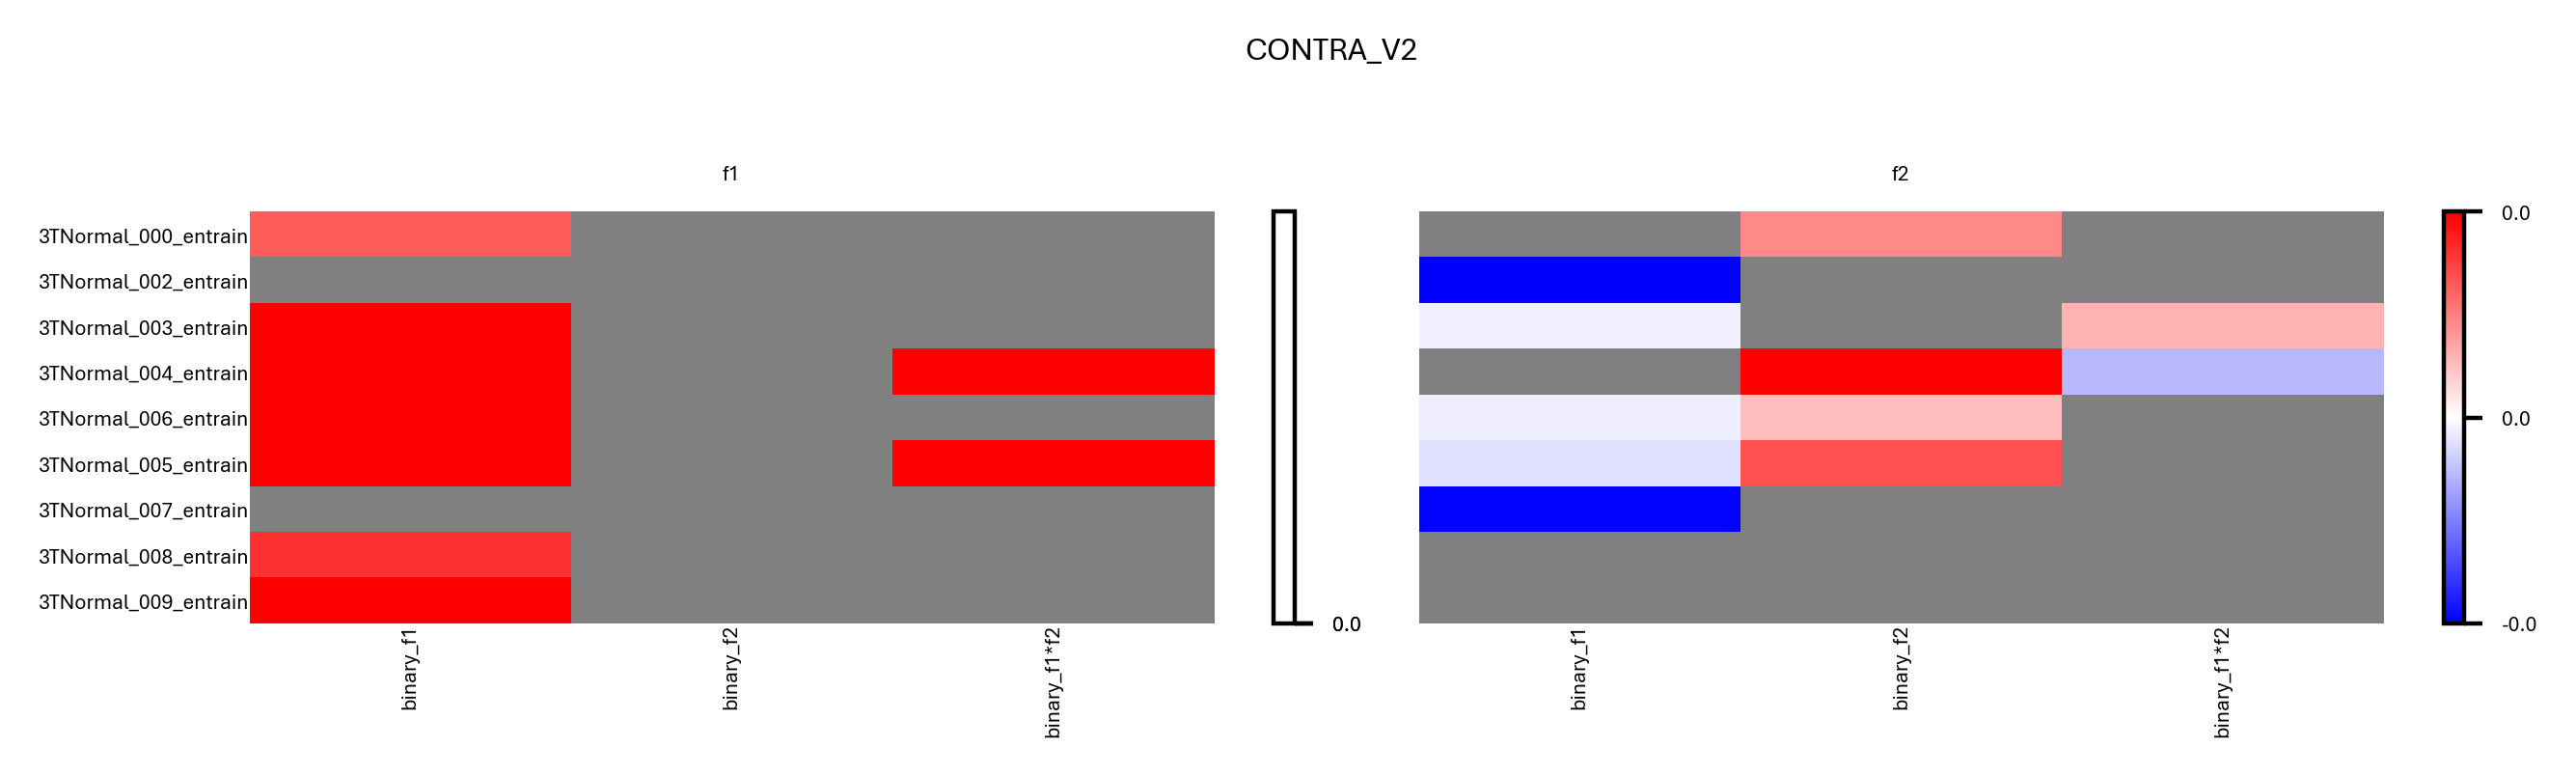

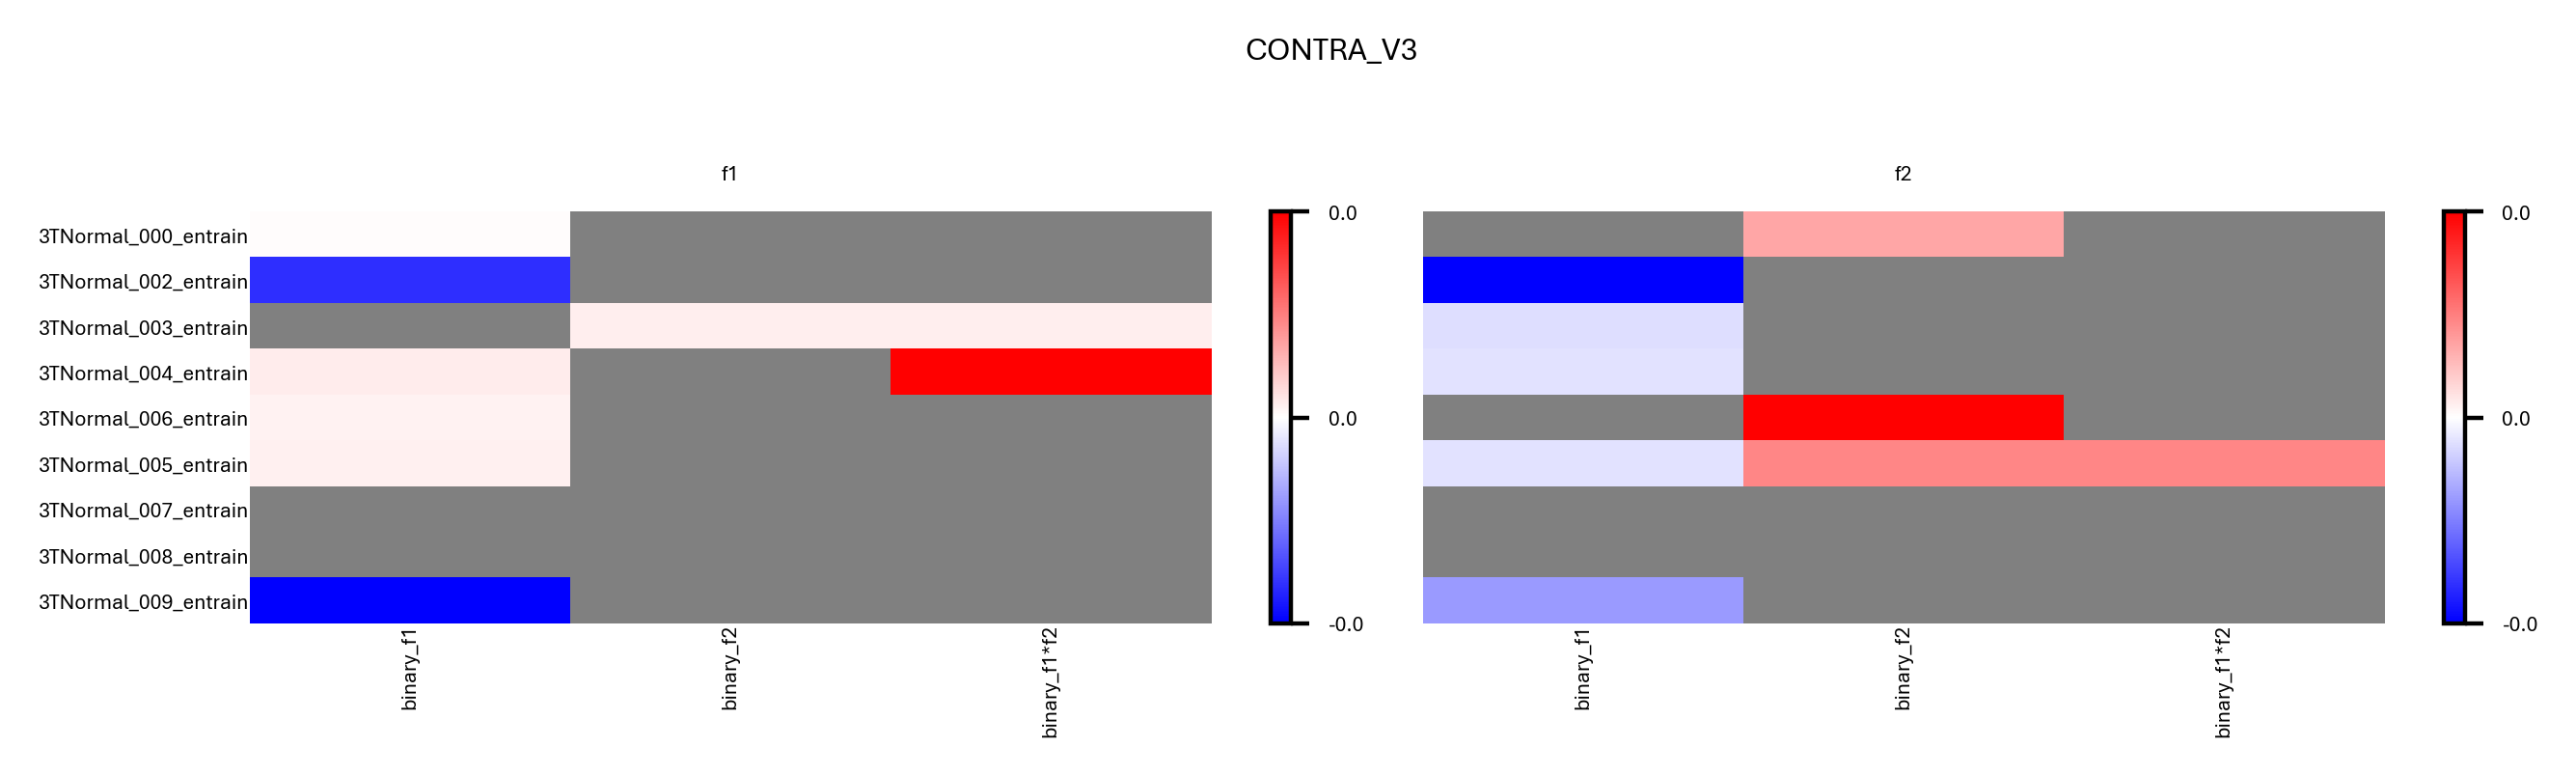

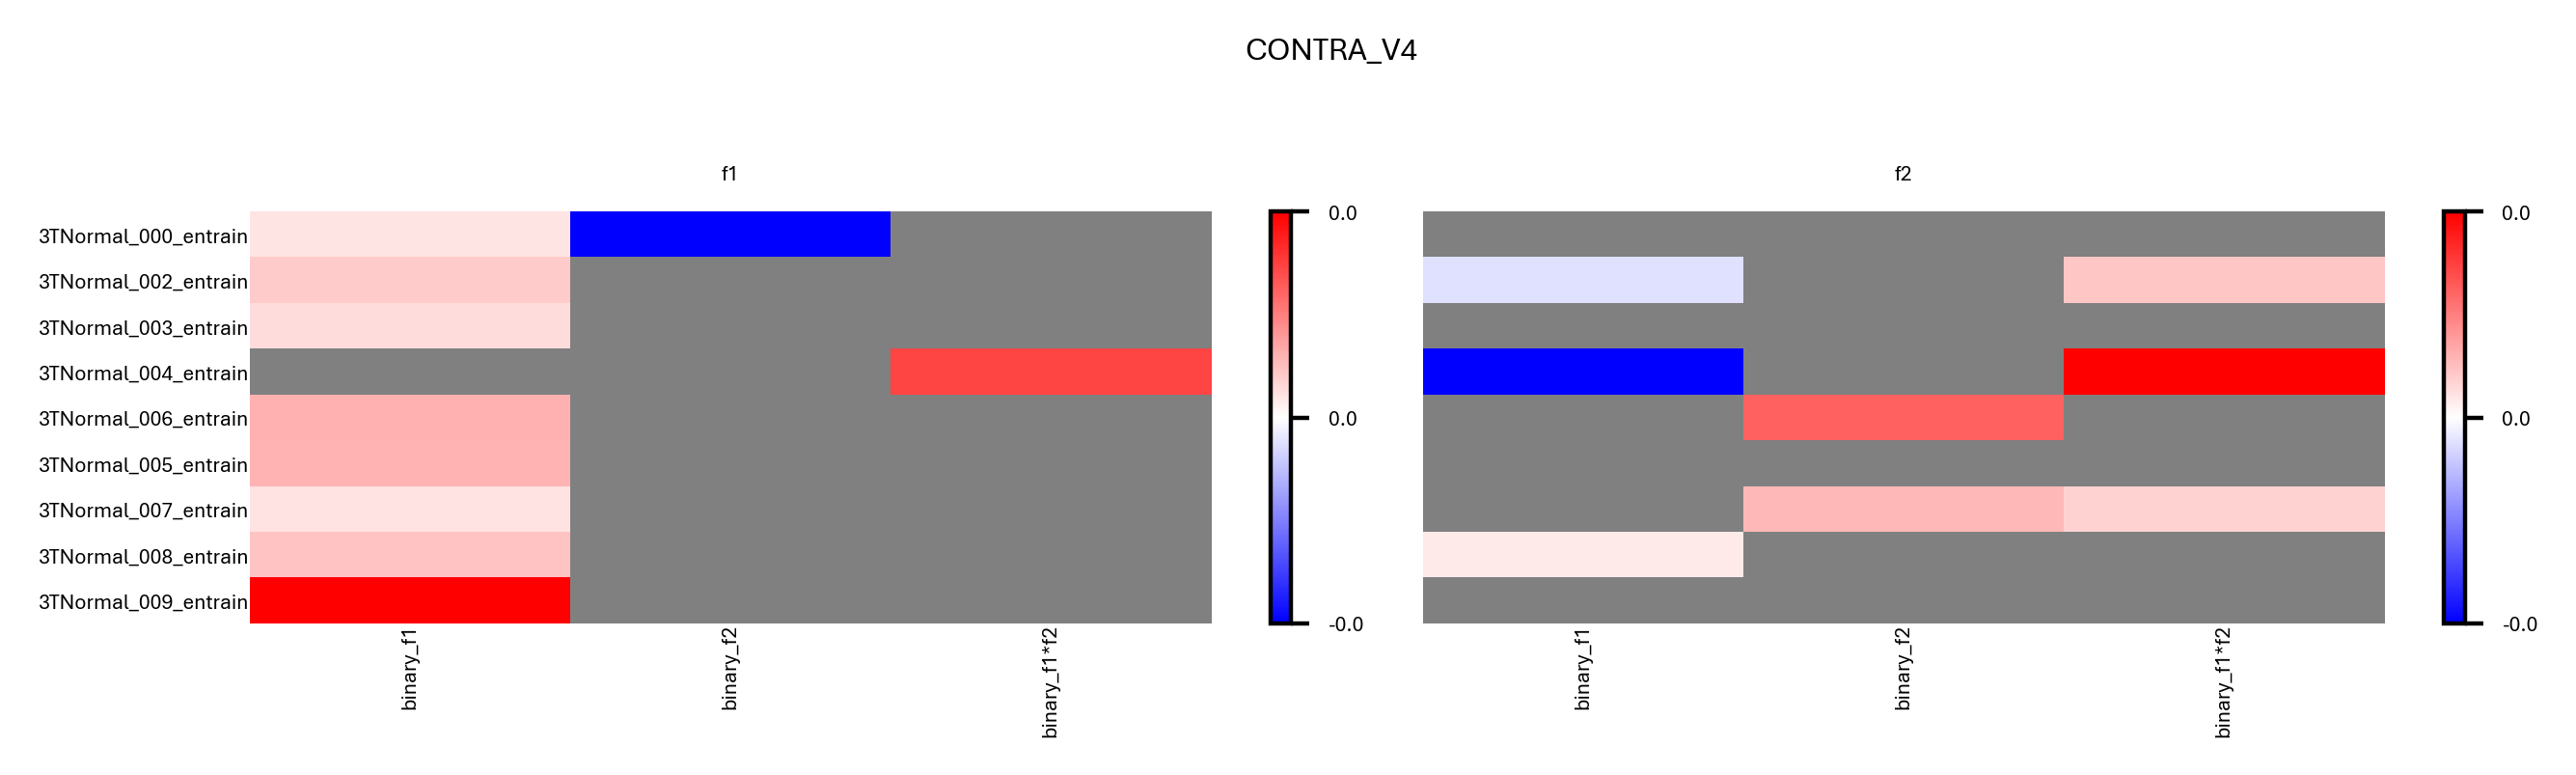

In [6]:

im_codes_to_include = ["f1","f2"]
filtered_expanded_df = expanded_df[(expanded_df.experiment_sub_id.str.endswith("entrain"))]
proportion_thr = 1

hcp_rois_to_include_in_analysis = []
for hcp_roi in filtered_expanded_df.hcp_roi.unique():
    experiments_with_im_codes = filter_experiments_with_frequency_encodings(filtered_expanded_df, hcp_roi, im_codes_to_include)
    proportion_experiments = len(experiments_with_im_codes) / len(filtered_expanded_df.experiment_sub_id.unique())
    if proportion_experiments >= proportion_thr:
        hcp_rois_to_include_in_analysis.append(hcp_roi)

n_experiments = len(filtered_expanded_df.experiment_sub_id.unique())
power_to_models = ["f1","f2"]
independent_vars = ["binary_f1", "binary_f2"]
n_params = 3 # binary_f1, binary_f2, binary_f1 * binary_f2, binary_f2_sub_f1 * binary_f1, binary_f2_sub_f1 * binary_f2, binary_f2_sub_f1 * binary_f1 * binary_f2

group_data = {"f1": None, "f2": None, "f2_sub_f1": None}
for hcp_roi in ["ALL"]+hcp_rois_to_include_in_analysis:
    stats_fill = generate_stats_dict_arr(
        power_to_models,
        len(filtered_expanded_df.experiment_sub_id.unique()),
        n_params # binary_f1, binary_f2, binary_f2_sub_f1, binary_2f1, hemi, gd
    )
    for experiment_ix, i in enumerate(filtered_expanded_df.experiment_sub_id.unique()):
        print(experiment_ix, i)
        roi_list = [hcp_roi]
        if hcp_roi == "ALL":
            roi_list = hcp_rois_to_include_in_analysis
        df_to_model = filtered_expanded_df[(filtered_expanded_df.hcp_roi.isin(roi_list))]
        experiment_id, sub_id, task_id = i.split("_")
        stats_fill, independent_vars_updated, X, y = model_individual_powers(
            stats_fill,
            experiment_ix,
            df_to_model,
            independent_vars,
            power_to_models,
            experiment_id,
            sub_id,
            task_id,
            setting=1,
        )
        for power_to_model in X.keys():
            _x = X[power_to_model].drop(columns=["const"])
            _x["power"] = y[power_to_model]
            _x["experiment_id"] = i
            
            if group_data[power_to_model] is None:
                group_data[power_to_model] = _x
            else:
                group_data[power_to_model] = pd.concat(
                    (group_data[power_to_model],_x), axis=0
                ).reset_index(drop=True)
    
    fig, ax_dict = plt.subplot_mosaic([power_to_models],dpi=400,figsize=(7,2), layout="tight")
    _title= hcp_roi
    if hcp_roi == "ALL":
        _title = ",".join(hcp_rois_to_include_in_analysis)
    fig.suptitle(_title,fontsize=6)

    for power_ix, power_to_model in enumerate(power_to_models):
        ax=ax_dict[power_to_model]
        masked_matrix = np.ma.masked_invalid(stats_fill[power_to_model])
        try:
            norm = mcolors.TwoSlopeNorm(vmin=masked_matrix.min(),vcenter=0,vmax=masked_matrix.max())
        except:
            print(masked_matrix.min(),masked_matrix.max())
        cmap = plt.get_cmap("bwr")
        cmap.set_bad(color="grey")
        cax = ax.imshow(masked_matrix,cmap=cmap,norm=norm,aspect="auto")
        cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
        cbar.ax.set_yticks([masked_matrix.min(),0,masked_matrix.max()])
        cbar.ax.set_yticklabels([f"{i:.1f}" for i in [masked_matrix.min(),0,masked_matrix.max()]],fontsize=4)
        for _spine in ["left","right","bottom","top"]:
            ax.spines[_spine].set_visible(False)

        yticks = [i for i in df_to_model.experiment_sub_id.unique()]
        xticks = [i for i in independent_vars_updated]

        if power_ix == 0:
            ax.set_yticks([i for i in range(len(yticks))])
            ax.set_yticklabels(yticks, fontsize=4)
        else:
            ax.set_yticks([])
        ax.set_xticks([i for i in range(len(xticks))])
        ax.set_xticklabels(xticks, fontsize=4, rotation=90)
        ax.set_title(power_to_model,fontsize=4)
        ax.tick_params(axis="both",width=.4, pad=0,length=0)

    fig.savefig(MAIN / f"Figure_X_power_dependencies_setting-1_in-{hcp_roi}.png")

Settings 2

0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
Skipping: [['CONTRA_V3']] 51159 has 1 rows
Skipping: [['CONTRA_V3']] 51370 has 1 rows
Skipping: [['CONTRA_V3']] 51371 has 1 rows
Skipping: [['CONTRA_V4']] 43005 has 1 rows
Skipping: [['CONTRA_V4']] 43115 has 1 rows
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
5 3TNormal_005_entrain
6 3TNormal_007_entrain
7 3TNormal_008_entrain
8 3TNormal_009_entrain
0 3TNormal_000_entrain
1 3TNormal_002_entrain
2 3TNormal_003_entrain
3 3TNormal_004_entrain
4 3TNormal_006_entrain
Skipping: [['CONTRA_V3']] 51159 has 1 rows
Skippi

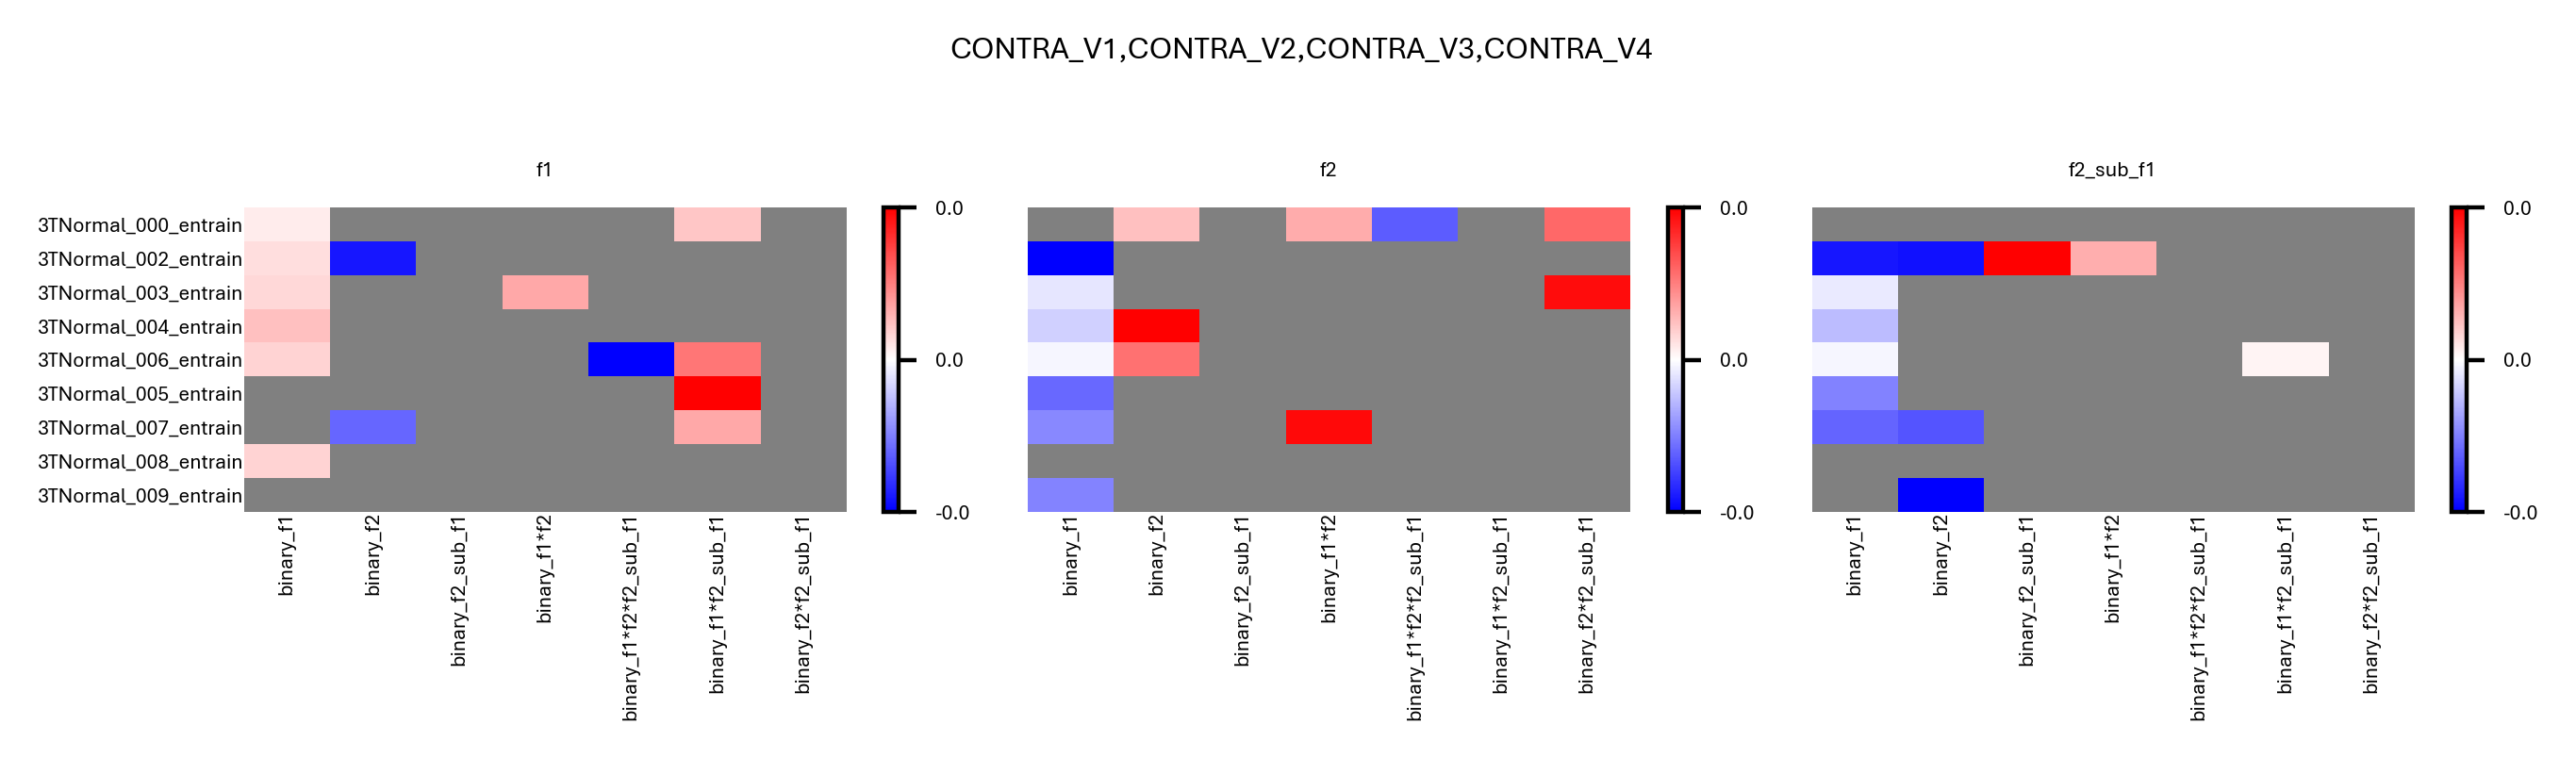

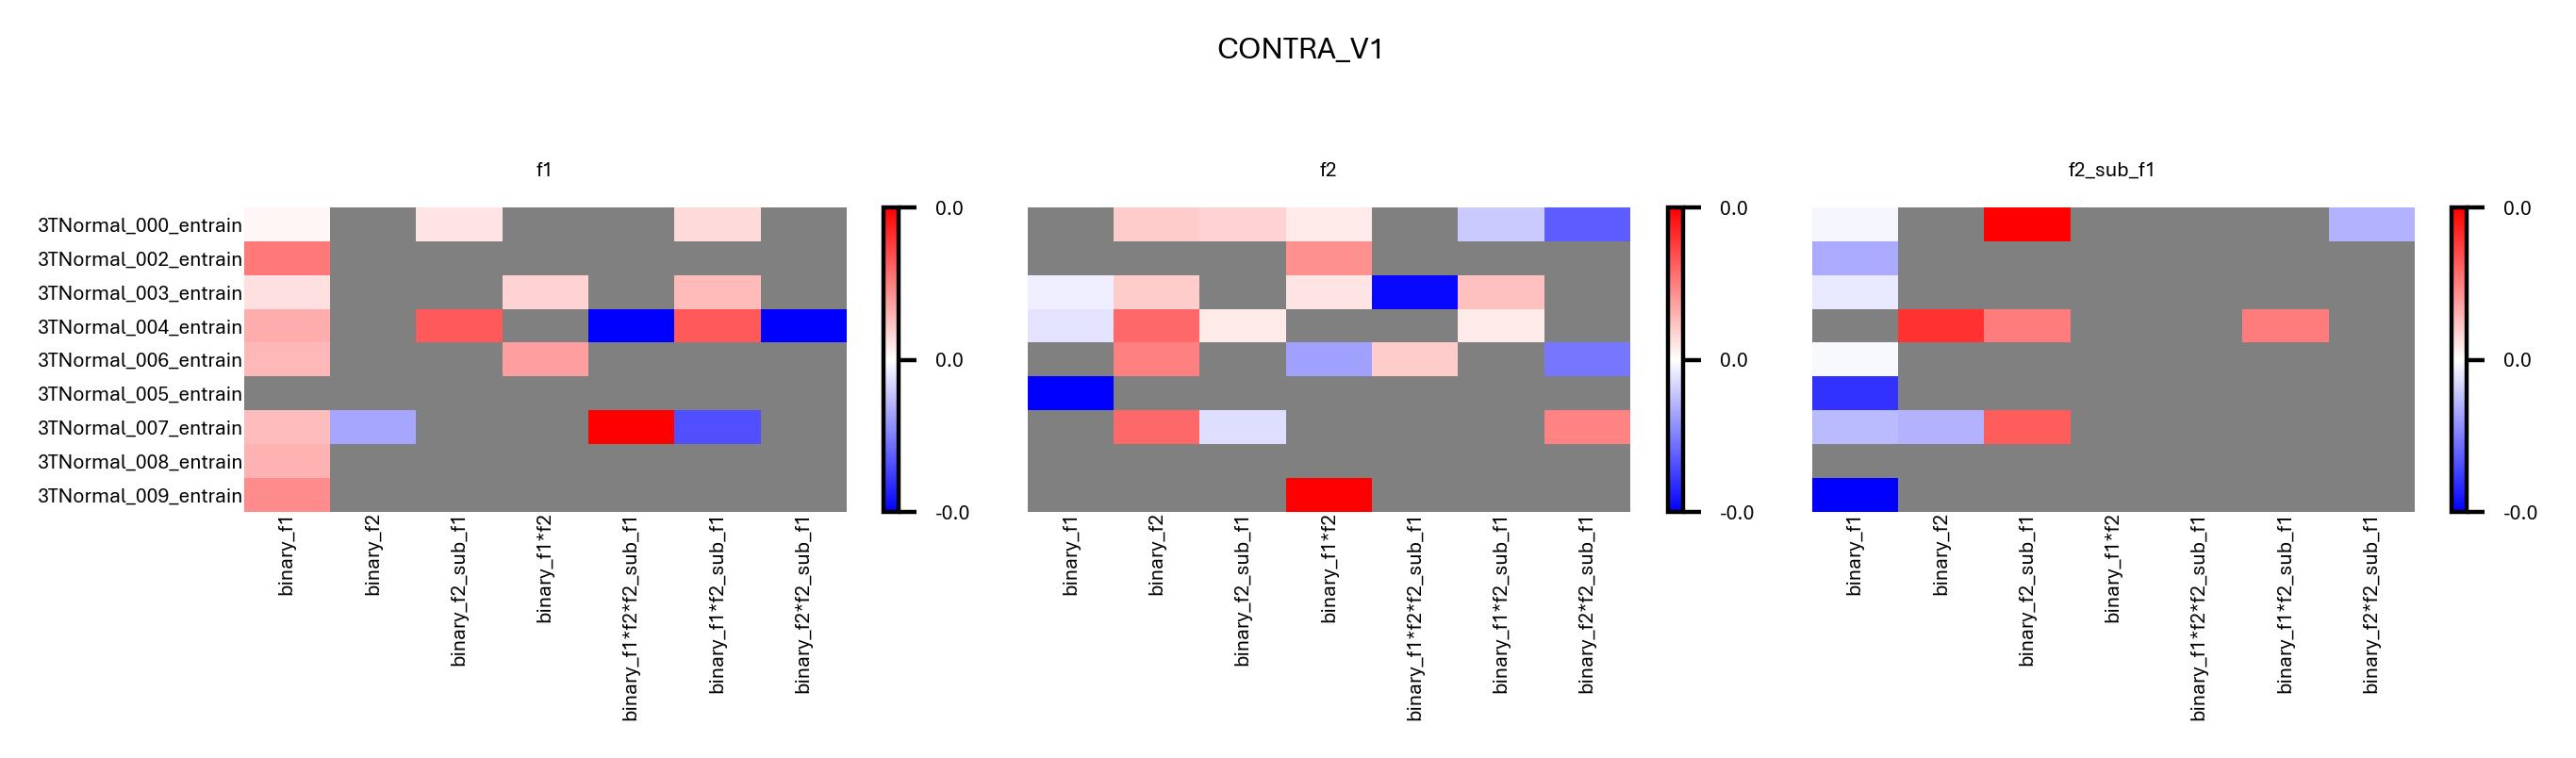

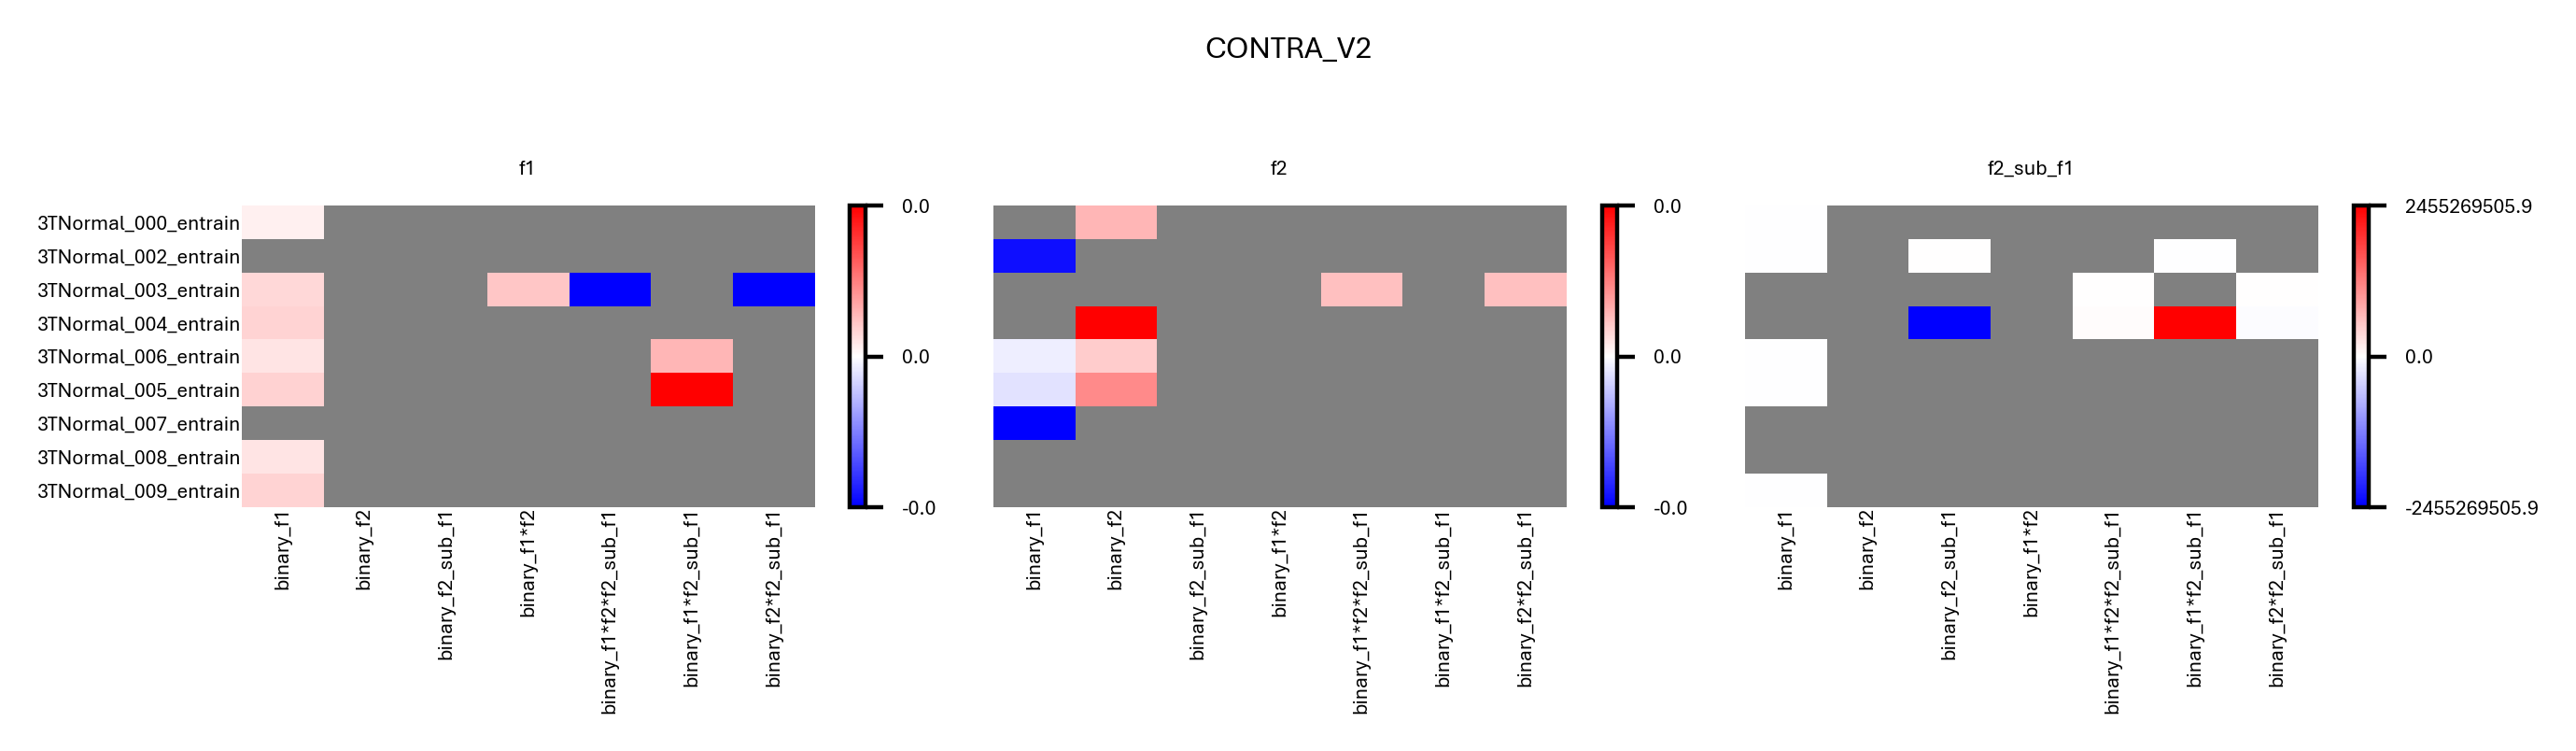

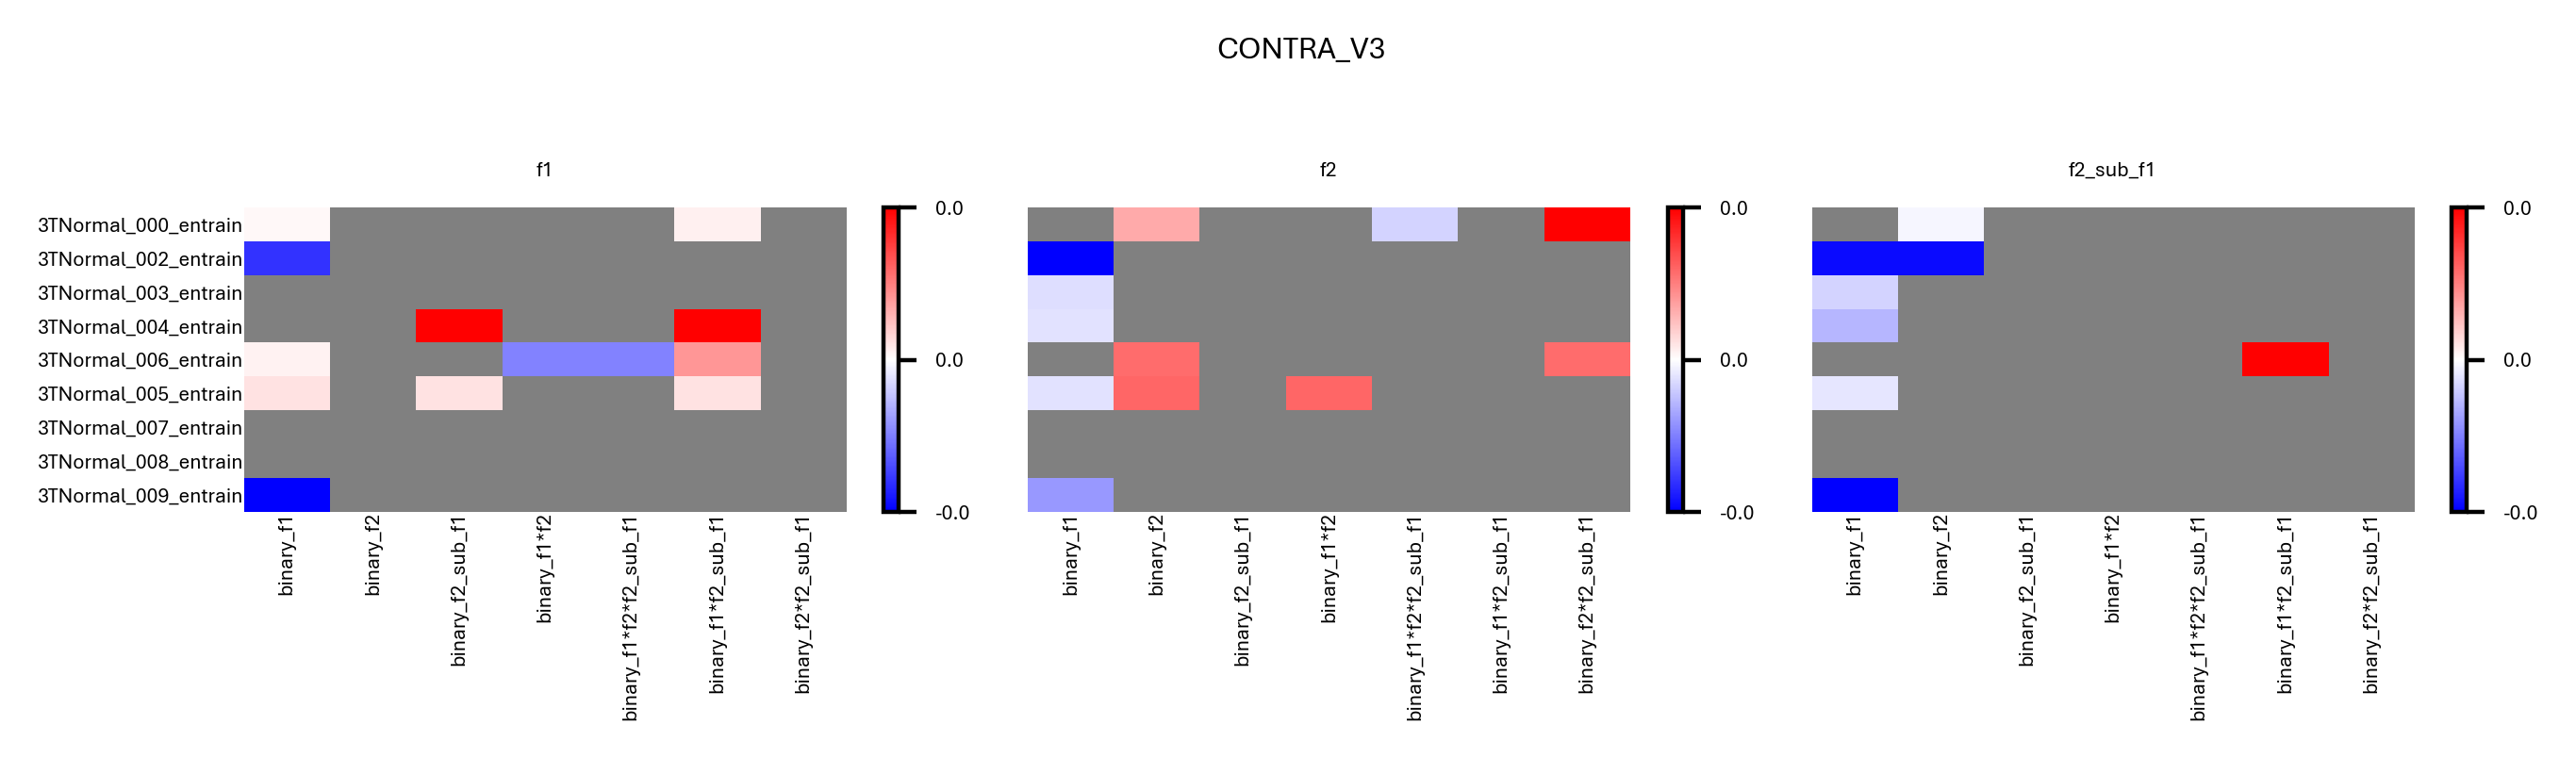

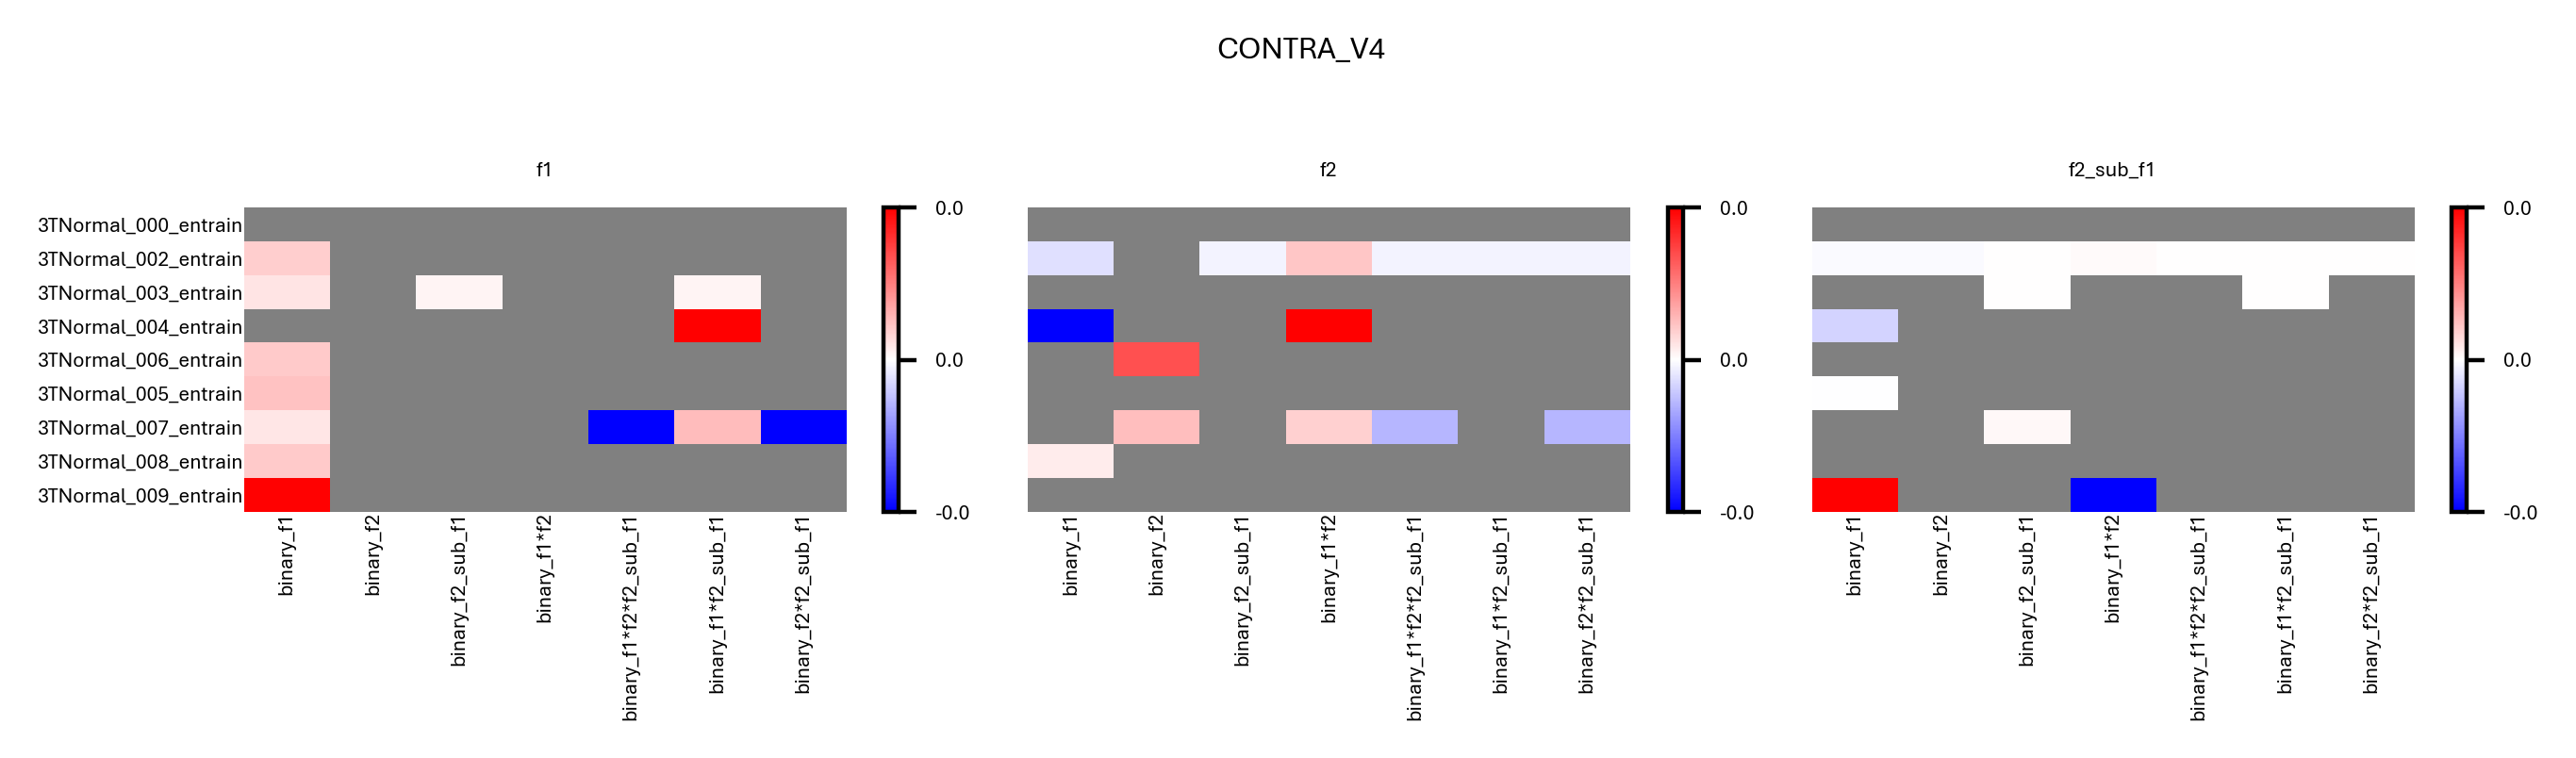

In [7]:
im_codes_to_include = ["f1","f2", "f2-f1"]
filtered_expanded_df = expanded_df[(expanded_df.experiment_sub_id.str.endswith("entrain"))]
proportion_thr = 1

hcp_rois_to_include_in_analysis = []
for hcp_roi in filtered_expanded_df.hcp_roi.unique():
    experiments_with_im_codes = filter_experiments_with_frequency_encodings(filtered_expanded_df, hcp_roi, im_codes_to_include)
    proportion_experiments = len(experiments_with_im_codes) / len(filtered_expanded_df.experiment_sub_id.unique())
    if proportion_experiments >= proportion_thr:
        hcp_rois_to_include_in_analysis.append(hcp_roi)

n_experiments = len(filtered_expanded_df.experiment_sub_id.unique())
power_to_models = ["f1","f2", "f2_sub_f1"]
independent_vars = ["binary_f1", "binary_f2", "binary_f2_sub_f1"]
n_params = 7 # binary_f1, binary_f2, binary_f1 * binary_f2, binary_f2_sub_f1 * binary_f1, binary_f2_sub_f1 * binary_f2, binary_f2_sub_f1 * binary_f1 * binary_f2

group_data = {"f1": None, "f2": None, "f2_sub_f1": None}
for hcp_roi in ["ALL"]+hcp_rois_to_include_in_analysis:
    stats_fill = generate_stats_dict_arr(
        power_to_models,
        len(filtered_expanded_df.experiment_sub_id.unique()),
        n_params # binary_f1, binary_f2, binary_f2_sub_f1, binary_2f1, hemi, gd
    )
    for experiment_ix, i in enumerate(filtered_expanded_df.experiment_sub_id.unique()):
        print(experiment_ix, i)
        roi_list = [hcp_roi]
        if hcp_roi == "ALL":
            roi_list = hcp_rois_to_include_in_analysis
        df_to_model = filtered_expanded_df[(filtered_expanded_df.hcp_roi.isin(roi_list))]
        experiment_id, sub_id, task_id = i.split("_")
        stats_fill, independent_vars_updated, X, y = model_individual_powers(
            stats_fill,
            experiment_ix,
            df_to_model,
            independent_vars,
            power_to_models,
            experiment_id,
            sub_id,
            task_id,
            setting=2,
        )
        if hcp_roi != "ALL":
            for power_to_model in X.keys():
                _x = X[power_to_model].drop(columns=["const"])
                _x["power"] = y[power_to_model]
                _x["experiment_id"] = i
                _x["hcp_roi"] = hcp_roi
                
                if group_data[power_to_model] is None:
                    group_data[power_to_model] = _x
                else:
                    group_data[power_to_model] = pd.concat(
                        (group_data[power_to_model],_x), axis=0
                    ).reset_index(drop=True)
    
    fig, ax_dict = plt.subplot_mosaic([power_to_models],dpi=400,figsize=(7,2), layout="tight")
    _title= hcp_roi
    if hcp_roi == "ALL":
        _title = ",".join(hcp_rois_to_include_in_analysis)
    fig.suptitle(_title,fontsize=6)

    for power_ix, power_to_model in enumerate(power_to_models):
        ax=ax_dict[power_to_model]
        masked_matrix = np.ma.masked_invalid(stats_fill[power_to_model])
        try:
            norm = mcolors.TwoSlopeNorm(vmin=masked_matrix.min(),vcenter=0,vmax=masked_matrix.max())
        except:
            print(masked_matrix.min(),masked_matrix.max())
        cmap = plt.get_cmap("bwr")
        cmap.set_bad(color="grey")
        cax = ax.imshow(masked_matrix,cmap=cmap,norm=norm,aspect="auto")
        cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
        cbar.ax.set_yticks([masked_matrix.min(),0,masked_matrix.max()])
        cbar.ax.set_yticklabels([f"{i:.1f}" for i in [masked_matrix.min(),0,masked_matrix.max()]],fontsize=4)
        for _spine in ["left","right","bottom","top"]:
            ax.spines[_spine].set_visible(False)

        yticks = [i for i in df_to_model.experiment_sub_id.unique()]
        xticks = [i for i in independent_vars_updated]

        if power_ix == 0:
            ax.set_yticks([i for i in range(len(yticks))])
            ax.set_yticklabels(yticks, fontsize=4)
        else:
            ax.set_yticks([])
        ax.set_xticks([i for i in range(len(xticks))])
        ax.set_xticklabels(xticks, fontsize=4, rotation=90)
        ax.set_title(power_to_model,fontsize=4)
        ax.tick_params(axis="both",width=.4, pad=0,length=0)

    fig.savefig(MAIN / f"Figure_X_power_dependencies_setting-2_in-{hcp_roi}.png")

/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2238: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)
/usr/local/lib/python3.10/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/local/lib/python3.10/dist-packages/statsmodels/regression/mixed_linear_model.py:2201: ConvergenceWarning: Retrying MixedLM optimization with lbfgs
  war

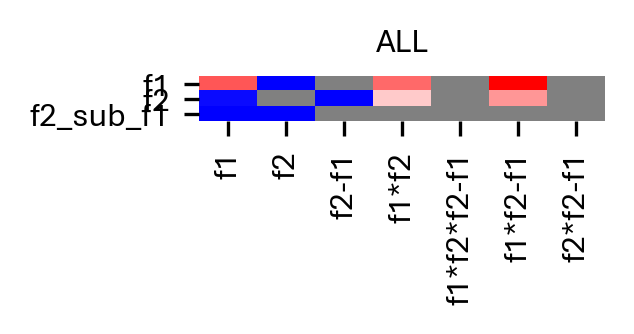

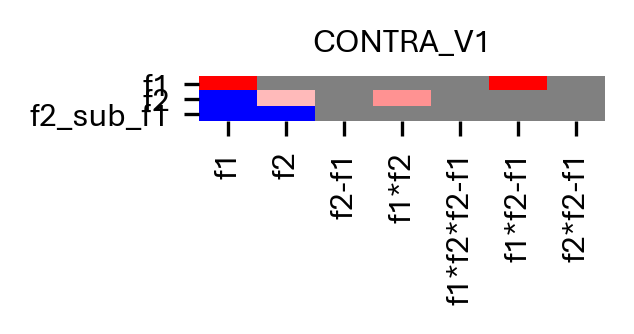

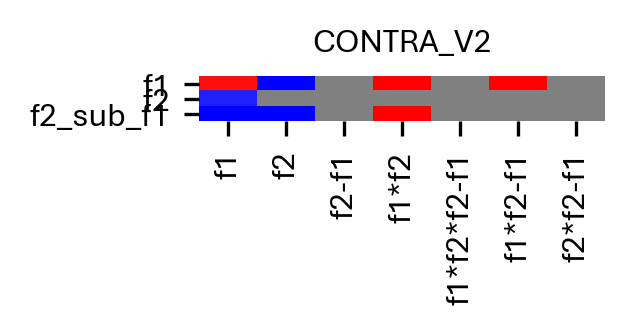

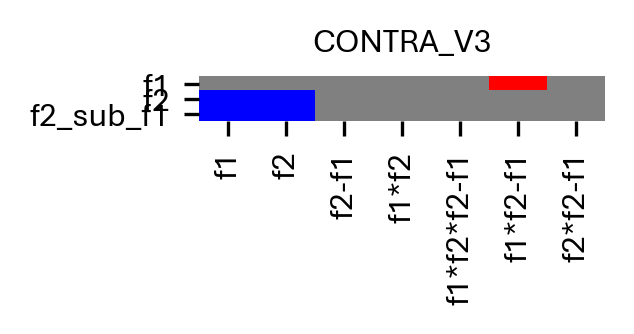

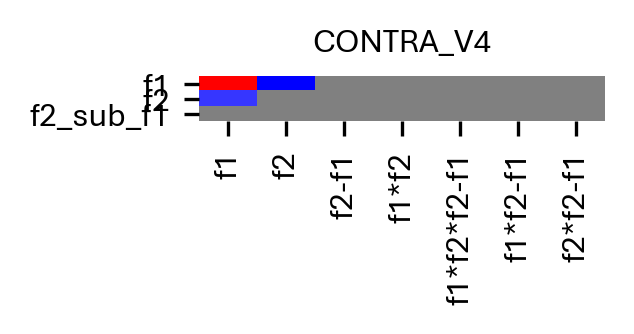

In [9]:
from statsmodels.formula.api import mixedlm

power_to_models = ["f1","f2","f2_sub_f1"]
modeled_populations = ["binary_f1","binary_f2","binary_f2_sub_f1","binary_f1_mul_f2","binary_f1_mul_f2_mul_f2_sub_f1","binary_f1_mul_f2_sub_f1","binary_f2_mul_f2_sub_f1"]

for hcp_roi in ["ALL","CONTRA_V1","CONTRA_V2","CONTRA_V3","CONTRA_V4"]:
    mixed_glm_cohort_pvalues = np.zeros((len(power_to_models),7))
    fig, ax = plt.subplots(figsize=(2,1), dpi=300, layout="constrained")
    for power_ix, power_to_model in enumerate(power_to_models):
        group_df = group_data[power_to_model]
        if hcp_roi.startswith("CONTRA_"):
            group_df = group_df[group_df.hcp_roi==hcp_roi]
        for col in group_df.columns:
            group_df = group_df.rename(columns={col: col.replace("*","_mul_")})
        formula  = "power ~ " + " + ".join(modeled_populations)
        # Mixed LM
        model = mixedlm(
            formula,
            group_df, 
            groups=group_df["experiment_id"]
        )
        result = model.fit()
        #print(result.summary())

        for i,m in enumerate(["binary_f1","binary_f2","binary_f2_sub_f1","binary_f1_mul_f2","binary_f1_mul_f2_mul_f2_sub_f1","binary_f1_mul_f2_sub_f1","binary_f2_mul_f2_sub_f1"]):
            pval = result.pvalues[m]
            coef = result.params[m]
            if pval < .05:
                mixed_glm_cohort_pvalues[power_ix,i] = coef
            else:
                mixed_glm_cohort_pvalues[power_ix,i] = np.nan

    cmap = plt.get_cmap("bwr")
    cmap.set_bad(color="grey")
    _max = np.nanmax(mixed_glm_cohort_pvalues)*.3
    _min = np.nanmin(mixed_glm_cohort_pvalues)*.3
    cax = ax.imshow(mixed_glm_cohort_pvalues,cmap=cmap,aspect="auto",vmax=_max,vmin=_min)
    #cbar = fig.colorbar(cax, ax=ax, orientation='vertical')
    #cbar.ax.set_yticks([masked_matrix.min(),0,masked_matrix.max()])
    #cbar.ax.set_yticklabels([f"{i:.1f}" for i in [masked_matrix.min(),0,masked_matrix.max()]],fontsize=4)
    for _spine in ["left","right","bottom","top"]:
        ax.spines[_spine].set_visible(False)
    ax.set_xticks([i for i in range(len(modeled_populations))])
    ax.set_xticklabels([i.split("binary_")[-1].replace("_mul_","*").replace("_sub_","-") for i in modeled_populations],fontsize=8,rotation=90)
    ax.set_yticks([i for i in range(len(power_to_models))])
    ax.set_yticklabels(power_to_models,fontsize=8)
    ax.set_title(hcp_roi, fontsize=8)
    fig.savefig(MAIN / f"Figure_X_across_3T_GROUP_power_dependencies_setting-2_in-{hcp_roi}.png")